# 9.7 Transfer Learning
############################################################################################################################
############################################################################################################################

## 1. Introduction

**What is transfer learning?**
- one of the most powerful ideas of deep learning
- taking knowledge learned from one task, and leveraging it on a similar but new task

**Why transfer learning?**
- big pre-trained models can be leveraged
- good accuracy with very little training (saves training time)
- allows training with very small training datasets

**When transfer learning for task-A$\rightarrow$task-B useful?**
- same input type for both tasks
- big training data for task-A, but small training data for task-B
- low-level features of task-A useful for learning task-B

**How to implement transfer learning?**
1. take a pre-trained network, and remove its last layer(s)
2. replace the weights feeding into the last layer(s) with a new set of randomly intialized weights
3. Add new trainable layer(s) on top of the remaining layers
4. retrain the neural network on the new dataset; depending on dataset size:
    - `pre-training`: retrain only the weights of the newly added layer(s), freeze all the other layers
    - `fine tuning`: retrain the newly added layer(s) as well as some/all of the other layers

############################################################################################################################
############################################################################################################################

## 2. Pre-trained Model

#### Load packages

In [2]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# miscellaneous
import scipy
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# deep learning stack
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.preprocessing import image

In [3]:
# tensorflow and keras version
print(f'TensorFlow version: {tf.__version__}')
print(f'Keras version: {keras.__version__}')

TensorFlow version: 2.11.0
Keras version: 2.11.0


**Load model**

In [4]:
# mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

**User-defined functions**

In [5]:
def image_resizing(image_path):
    """
    This function resizes an input image to 224 X 224
    """
    img = image.load_img(image_path, target_size=(224,224))
    return img

In [6]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
 
def image_preprocessing(resized_image):
    """
    This function preprocesses the input image for MobileNetV2
    """
    pic_array = image.img_to_array(resized_image)
    image_batch = np.expand_dims(pic_array, axis=0)
    processed_image = preprocess_input(image_batch)
    return processed_image

In [7]:
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

def image_class_prediction(model, preprocessed_image):
    """
    This function spits out the top-5 predictions 
    for a given model with a proprocessed image
    """
    model_prediction = model.predict(preprocessed_image,verbose=0)
    decoded_prediction = decode_predictions(model_prediction,top=5)[0]
    data = {'image_class': [_[1] for _ in decoded_prediction],
            'probability': [_[2] for _ in decoded_prediction]
           }
    df = pd.DataFrame(data=data)
    return df

**Instantiate model**

In [8]:
pretrained_model = MobileNetV2(weights='imagenet')

**Model summary**

In [9]:
pretrained_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**Model evaluation**

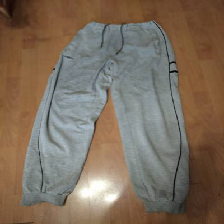

In [13]:
# resize and show image
resized_image = image_resizing('test/pants/0dfec862-c49f-430b-a6ef-c7ceb187225e.jpg')
resized_image

In [14]:
# preprocess an image
preprocessed_img = image_preprocessing(resized_image)

# class prediction
image_class_prediction(pretrained_model, preprocessed_img)

,image_class,probability
0,jean,0.487726
1,sleeping_bag,0.055541
2,diaper,0.042107
3,swab,0.030796
4,swimming_trunks,0.023560


############################################################################################################################
############################################################################################################################

## 3. Transfer Learning Example

**Getting new training images into keras**

In [15]:
# this are the folder names
classes = os.listdir('train')
classes

['t-shirt',
 'skirt',
 'pants',
 'shirt',
 'dress',
 'hat',
 'shoes',
 'shorts',
 'outwear',
 'longsleeve']

In [16]:
# define an image data generator
data_gen = keras.preprocessing.image.ImageDataGenerator(
    # define the preprocessing function to be applied to all images
    preprocessing_function=preprocess_input
)

In [17]:
# a generator that returns batches of X and y arrays
train_data_gen = data_gen.flow_from_directory(
        directory='./train',
        class_mode="categorical",
        classes=classes,
        batch_size=300,
        target_size=(224, 224)
)

Found 3068 images belonging to 10 classes.


In [18]:
# load in all images at once
xtrain, ytrain = next(train_data_gen)
xtrain.shape, ytrain.shape

((300, 224, 224, 3), (300, 10))

### 3.1 Model Building 

**3.1.1 Select the convolutional base and freeze the weights**

In [19]:
base_model = MobileNetV2(
    weights='imagenet', 
    alpha=1.0,         # specific parameter of this model, small alpha reduces the number of overall weights
    pooling='avg',      # applies global average pooling to the output of the last conv layer (like a flattening)
    include_top=False,  # we only want to have the base, not the final dense layers 
    input_shape=(224, 224, 3)
)

# freeze it!
base_model.trainable = False

In [20]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

**3.1.2 Add dense layers on top**

In [21]:
def model_builder(hp):
    '''
    Args:
    hp - Keras tuner object
    '''
    # Initialize the Sequential API and start stacking the layers
    model = keras.Sequential()
    model.add(base_model)
    
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-160
    hp_units = hp.Int('units', min_value=32, max_value=160, step=32)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Add next layers
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(len(classes), activation='softmax'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
              loss=keras.losses.categorical_crossentropy,
              metrics=[keras.metrics.categorical_accuracy])


    return model

### 3.2 Hyperparameter Tuning

In [22]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, # the hypermodel
                     objective='val_categorical_accuracy', # objective to optimize
                     max_epochs=50,
                     hyperband_iterations=3,
                     project_name='tuning_results')

In [23]:
# hypertuning settings
tuner.search_space_summary() 

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 160, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [25]:
# Perform hypertuning
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tf.autograph.experimental.do_not_convert
tuner.search(xtrain, ytrain,
             epochs=50,
             batch_size=16,
             callbacks=[stop_early],
             validation_split=1/6)

Trial 14 Complete [00h 01m 08s]
val_categorical_accuracy: 0.30000001192092896

Best val_categorical_accuracy So Far: 0.7599999904632568
Total elapsed time: 01h 50m 59s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# best hyperparameters
best_hp=tuner.get_best_hyperparameters(1)[0]

In [ ]:
# Build the model with the optimal hyperparameters
h_model = tuner.hypermodel.build(best_hp)
h_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dense_2 (Dense)             (None, 160)               204960    
                                                                 
 dropout_1 (Dropout)         (None, 160)               0         
                                                                 
 dense_3 (Dense)             (None, 3)                 483       
                                                                 
Total params: 2,463,427
Trainable params: 205,443
Non-trainable params: 2,257,984
_________________________________________________________________


### 3.3 Model Training

In [ ]:
tf.autograph.experimental.do_not_convert
h_model.fit(xtrain, ytrain,
            epochs=50,
            batch_size=16,
            callbacks=[stop_early],
            validation_split=1/6)

Epoch 1/50
16/16 [==============================] - 5s 243ms/step - loss: 1.8436 - categorical_accuracy: 0.7200 - val_loss: 0.4650 - val_categorical_accuracy: 0.9200
Epoch 2/50
16/16 [==============================] - 3s 210ms/step - loss: 0.1377 - categorical_accuracy: 0.9560 - val_loss: 0.2773 - val_categorical_accuracy: 0.9400
Epoch 3/50
16/16 [==============================] - 3s 210ms/step - loss: 0.1273 - categorical_accuracy: 0.9800 - val_loss: 0.2274 - val_categorical_accuracy: 0.9600
Epoch 4/50
16/16 [==============================] - 3s 212ms/step - loss: 0.1424 - categorical_accuracy: 0.9600 - val_loss: 0.1199 - val_categorical_accuracy: 0.9600
Epoch 5/50
16/16 [==============================] - 3s 210ms/step - loss: 0.0870 - categorical_accuracy: 0.9800 - val_loss: 0.3546 - val_categorical_accuracy: 0.9000
Epoch 6/50
16/16 [==============================] - 3s 212ms/step - loss: 0.1336 - categorical_accuracy: 0.9640 - val_loss: 0.2680 - val_categorical_accuracy: 0.9400
Epoc

In [ ]:
losses = pd.DataFrame(h_model.history.history) # losses in the training history
epoch = losses.index.values+np.ones_like(losses.index.values) # epoch number
loss = losses['loss'].values # training loss
val_loss = losses['val_loss'].values # validation loss

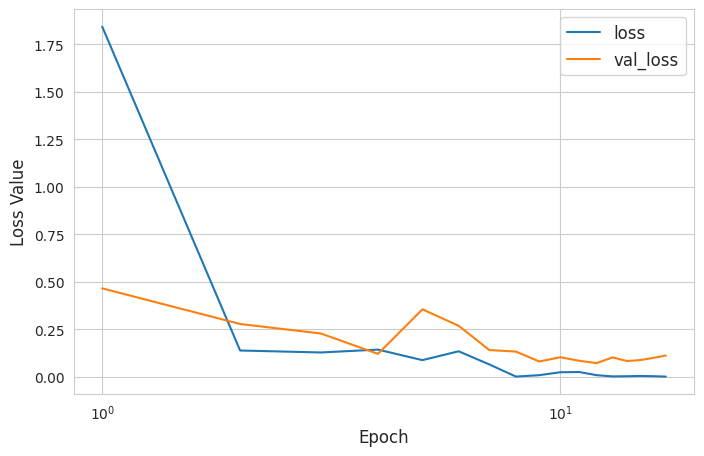

In [ ]:
# plot losses against epoch number in log-scale
plt.figure(figsize=(8,5),dpi=100)
plt.semilogx(epoch, loss, linewidth=1.5, label='loss')
plt.semilogx(epoch, val_loss, linewidth=1.5, label='val_loss')
plt.xlabel('Epoch',fontsize=12)
plt.ylabel('Loss Value',fontsize=12)
plt.legend(loc=1,fontsize=12)
None

### 3.4 Model Evaluation

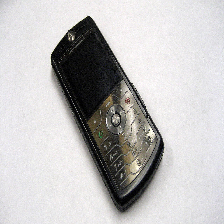

In [ ]:
# resize and show image
resized_image = image_resizing('test_images/phone_3.png')
resized_image

In [ ]:
# preprocess an image
preprocessed_img = image_preprocessing(resized_image)

In [ ]:
def image_classification(preprocessed_image, model):
    probs = model.predict(preprocessed_image)[0].tolist()
    zipped = sorted(list(zip(classes, probs)), key=lambda x: x[1], reverse=True)
    image_class = [zipped[i][0] for i in range(len(zipped))]
    probability  = [zipped[i][1]*100 for i in range(len(zipped))]
    df = pd.DataFrame(data={'image_class':image_class, 'probability(%)': probability})
    return df

In [ ]:
tf.autograph.experimental.do_not_convert
image_classification(preprocessed_img, h_model)

1/1 [==============================] - 0s 341ms/step


,image_class,probability(%)
0,phone,1.000000e+02
1,fork,6.900857e-07
2,book,5.910871e-08


############################################################################################################################
############################################################################################################################

## References

1. [Transfer Learning, Andrew Ng](https://www.youtube.com/watch?v=yofjFQddwHE)

2. [Hyperband: A Novel Bandit-Based Approach to Hyperparameter Optimization
](https://jmlr.org/papers/v18/16-558.html)